In [2]:
import jsonlines
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import figure
import seaborn as sb
from statistics import mean
import numpy as np
import numba as nb
from numba import njit
from numba.core import types
from numba.typed import Dict

# Kiva Experiments

In [3]:
BORDA_LOT = "../data/history_file_product_lottery_borda_kiva.json"
BORDA_WEIGHT = "../data/history_file_weighted_alloc_borda_kiva.json"
BORDA_LEAST = "../data/history_file_least_fair_borda_kiva.json"


COPELAND_LOT = "../data/history_file_product_lottery_copeland_kiva.json"
COPELAND_WEIGHT = "../data/history_file_weighted_alloc_copeland_kiva.json"
COPELAND_LEAST = "../data/history_file_least_fair_copeland_kiva.json"


RP_LOT = "../data/history_file_product_lottery_rankedpairs_kiva.json"
RP_WEIGHT = "../data/history_file_weighted_alloc_rankedpairs_kiva.json"
RP_LEAST = "../data/history_file_least_fair_rankedpairs_kiva.json"

WEIGHT_LEAST = "../data/history_file_least_fair_weighted_kiva.json"
WEIGHT_LOT = "../data/history_file_product_lottery_rescore_kiva.json"
WEIGHT_WEIGHT = "../data/history_file_weighted_alloc_weighted_kiva.json"

BASELINE = "../data/history_file_baseline_kiva.json"

recs_file = "../data/kiva_recs.csv"
items_file = "../data/kiva_item.csv"

In [4]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'COUNTRY_low_pfr') | (item_features['Feature'] == 'loan_buck_5')]

In [5]:
dataset = item_features

# Create a list of all feature combinations
all_features = ["COUNTRY_low_pfr", "loan_buck_5"]

# Iterate over each item ID and feature combination
for item_id in range(1, 4998):
    for feature in all_features:
        # Check if the row exists
        row_exists = ((dataset["Item"] == item_id) & (dataset["Feature"] == feature)).any()

        # If the row doesn't exist, add a new row with item ID, feature, and value of 0
        if not row_exists:
            dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\

item_features = dataset

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/226915423.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/226915423.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/226915423.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/22691

In [6]:
# no need to change unless changing allocation/choice mechanism
history_files = [BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_LEAST,COPELAND_LOT,COPELAND_WEIGHT,RP_LEAST,RP_LOT,RP_WEIGHT,WEIGHT_LEAST, WEIGHT_LOT,WEIGHT_WEIGHT,BASELINE]


mechanisms = ['Borda Lottery', 'Borda Weighted Product',
                  'Borda Least Fair','Copeland Least Fair',
                  'Copeland Lottery', 'Copeland Weighted Product',
                  'Ranked Pairs Least Fair',
                  'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product','Weighted Rescore Least Fair','Weighted Rescore Lottery',
                  'Weighted Rescore Weighted Product', 'Baseline']

In [7]:
# TODO: streamline data collection
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [8]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicitly determined. Defaulting to integer...")
        var = int(var)
    return var

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [9]:
light_histories = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.DictType(types.unicode_type, types.float64[:]),
)
for history in processed_histories:
    consolidated_statistics = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64[:]
    )
    for user, items in processed_histories[history]["Statistics"].items():
        consolidated_statistics[user] = np.asarray(items, dtype='f8')
    light_histories[history] = consolidated_statistics

light_recommender = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.UniTuple(types.float64[:], 2),
)
for user in recommender["User"].unique():
    scores = recommender[recommender["User"] == user]["Score"].to_numpy(dtype='f8')
    items = recommender[recommender["User"] == user]["Item"].to_numpy(dtype='f8')
    light_recommender[user] = (scores, items)

In [10]:
rec_list = 10
base_logs = np.log2(np.arange(rec_list)+2)

@njit
def calculate_ndcg(histories, recommender, base_logs):
    avg_of_ndcg = []
    for history in histories:
        i_count = 0
        all_ndcg = 0
        for user, items in histories[history].items():
            scores = []
            for item in items:
                idx_array = np.asarray(recommender[user][1] == item).nonzero()[0]
                if idx_array.size != 0:
                    idx = idx_array[0]
                    score = recommender[user][0][idx]
                else:
                    score = 0.0
                scores.append(score)
            scores = np.asarray(scores)
            ideal_scores = np.sort(recommender[user][0])[::-1][:len(scores)]
            scores[scores > 0] = 1.0
            ideal_scores[ideal_scores > 0] = 1.0
            recdcg = np.sum(scores/base_logs)
            idealdcg = np.sum(ideal_scores/base_logs)
            if idealdcg == 0.0:
                ndcg = 0.0
            else:
                ndcg = recdcg/idealdcg
            i_count += 1
            all_ndcg += ndcg

        avg_of_ndcg.append(all_ndcg/i_count)
    return avg_of_ndcg

In [11]:
avg_of_ndcg = calculate_ndcg(light_histories, light_recommender, base_logs)

In [12]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

,NDCG
Borda Lottery,0.999945
Borda Weighted Product,0.999945
Borda Least Fair,0.999945
Copeland Least Fair,0.999945
Copeland Lottery,0.999945
Copeland Weighted Product,0.999945
Ranked Pairs Least Fair,0.999945
Ranked Pairs Lottery,1.000000
Ranked Pairs Weighted Product,0.999945
Weighted Rescore Least Fair,0.999976


In [13]:
# calculates proportional fairness for the representation of item features
num_features = 10
feature_names = ["COUNTRY_low_pfr", "loan_buck_5"]
protected_features = ["COUNTRY_low_pfr", "loan_buck_5"]
fairness_targets = [0.20, 0.20]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [14]:
prop_fairness_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [15]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [20]:
### VISUALIZATION FUNCTIONS ###
# TODO: Update viz functions to make them more efficient and inline with statistics

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['COUNTRY_low_pfr'] == 0) & (alloc_df['loan_buck_5'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)

def process_names(name):
    orig_name = name
    for alloc in ["Baseline","Lottery","Weighted Product","Least Fair"]:
        name = name.replace(alloc, "")
        if name != orig_name:
            return name.rstrip(), alloc

In [21]:
experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["COUNTRY_low_pfr","loan_buck_5"],var_name='Agent', value_name="Fairness")

In [22]:
baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "COUNTRY_low_pfr"]["Fairness"].mean()
baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "loan_buck_5"]["Fairness"].mean()
boxplots = experiments[experiments["Allocation Mech"] != "Baseline"]

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/4195476474.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "COUNTRY_low_pfr"]["Fairness"].mean()
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/4195476474.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "loan_buck_5"]["Fairness"].mean()


In [23]:
boxplots.loc[boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
boxplots.loc[boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"
boxplots.replace("COUNTRY_low_pfr", "Country", inplace=True)
boxplots.replace("loan_buck_5", "Loan Size", inplace=True)

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/1440674392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplots.replace("COUNTRY_low_pfr", "Country", inplace=True)
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_52920/1440674392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplots.replace("loan_buck_5", "Loan Size", inplace=True)


/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


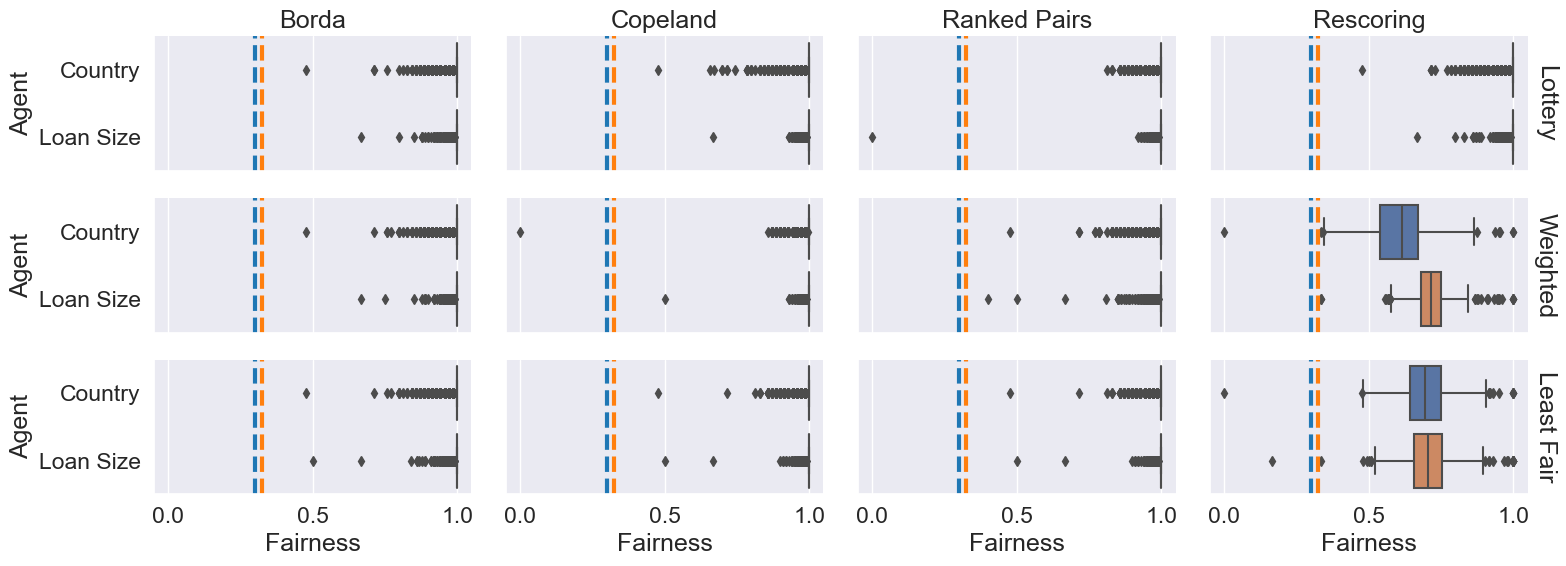

In [24]:
sb.set(font_scale=1.5)

g = sb.catplot(data=boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["Country","Loan Size"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

In [27]:
ndcg_fairness

,COUNTRY_low_pfr,loan_buck_5,NDCG
Borda Lottery,0.925468,0.028839,0.999945
Borda Weighted Product,0.923471,0.029338,0.999945
Borda Least Fair,0.926342,0.027840,0.999945
Copeland Least Fair,0.930337,0.029213,0.999945
Copeland Lottery,0.928589,0.030087,0.999945
Copeland Weighted Product,0.913983,0.029588,0.999945
Ranked Pairs Least Fair,0.930337,0.029213,0.999945
Ranked Pairs Lottery,0.928964,0.029838,1.000000
Ranked Pairs Weighted Product,0.927840,0.029338,0.999945
Weighted Rescore Least Fair,1.664295,0.086392,0.999976


In [28]:
baseline_accuracy = ndcg_fairness.loc["Baseline"]
ndcg_fairness = ndcg_fairness.drop("Baseline")

In [29]:
ndcg_fairness['Choice'] = ('Borda', 'Borda', 'Borda', 'Copeland', 'Copeland', 'Copeland', 'Ranked Pairs', 'Ranked Pairs', 'Ranked Pairs', 'Rescoring', 'Rescoring', 'Rescoring')
ndcg_fairness['Allocation'] = ('Lottery', 'Weighted', 'Least Fair', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted')

In [30]:
ndcg_fairness["Average Fairness Score"] = ndcg_fairness.apply(lambda x: (x["COUNTRY_low_pfr"]+x["loan_buck_5"])/2, axis=1)

In [31]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    #plt.legend(loc="lower left", fontsize=12)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

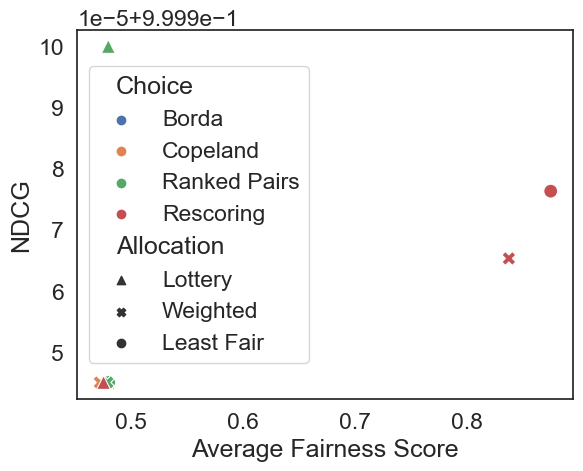

In [32]:
make_scatterplot(ndcg_fairness, baseline_accuracy, filename='kiva_scatter.png')